In [1]:
import pandas as pd
import numpy as np
import datetime
# import pyxirr
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.foreignexchange import ForeignExchange
from alpha_vantage.fundamentaldata import FundamentalData
# from alpha_vantage.foreignexchange import ForeignExchange
# from alpha_vantage.fundamentaldata import FundamentalData
from secrets import ROOT, ALPHAVANTAGE_API_KEY, ACCOUNT_CURRENCY

In [2]:
class av:
    try:
        ts = TimeSeries(key=ALPHAVANTAGE_API_KEY, output_format='pandas', indexing_type='date')
        cc = ForeignExchange(key=ALPHAVANTAGE_API_KEY, output_format='pandas', indexing_type='date')
        fd = FundamentalData(key=ALPHAVANTAGE_API_KEY, output_format='pandas')

    except ValueError:
        print('Please provide a valid AlphaVantage API key.\nGet a free key from https://www.alphavantage.co/support/#api-key')

In [3]:
class Orders:
    
    ACCOUNT = ['deposit', 'withdrawal']
    SECURITY = ['purchase', 'sale']

class Tickers:

    US = np.genfromtxt(ROOT+'/assets/us_tickers.csv', dtype=str, delimiter=',')
    CURRENCIES = np.genfromtxt(ROOT+'/assets/currencies.csv', dtype=str, delimiter=',')

class Transactions:

    def new(self):

        COLS = ['Date','Ticker', 'Order', 'Price', 'Quantity', 'Fee']
        self.data = pd.DataFrame(columns=COLS)

    def __init__(self):
        self.new()

    @staticmethod
    def validate(date, ticker, order, price, quantity, fee):

        ticker = ticker.upper()
        ACCOUNT_TRANSACTION = (True if ticker == 'CASH.' + ACCOUNT_CURRENCY else False)
        ORDERS = (Orders.ACCOUNT if ACCOUNT_TRANSACTION else Orders.SECURITY)

        try: 
            date = datetime.datetime.strptime(date, '%Y-%m-%d')
        except ValueError:
            return print(f'{date} does not match format %Y-%m-%d (1970-01-01)'), None

        if not isinstance(ticker, str):
            # raise TypeError('Ticker is mandatory and should be a string.')
            return print('Ticker is mandatory and should be a string.'), None
        elif not ACCOUNT_TRANSACTION and not (ticker in Tickers.US):
            # raise Exception(f'{ticker} is not available.')
            return print(f'{ticker} is not available.'), None

        if not isinstance(order, str):
            # raise TypeError('Order is mandatory and should be a string.')
            return print('Order is mandatory and should be a string.'), None
        elif not (order in ORDERS):
            # raise Exception(f'{order} is not a valid order. Valid orders are {ORDERS}')
            return print(f'{order} is not a valid order. Valid orders are {ORDERS}'), None

        if not isinstance(price, (int, float)):
            # raise TypeError('Price is mandatory and should be a number.')
            return print('Price is mandatory and should be a number.'), None

        if not isinstance(quantity, (int, float)):
            # raise TypeError('Quantity is mandatory and should be a number.')
            return print('Quantity is mandatory and should be a number.'), None

        if not isinstance(fee, (int, float)):
            # raise TypeError('Fee should be a number.')
            return print('Fee should be a number.'), None

        TRANSACTION = {
            'Date' : date,
            'Ticker' : ticker,
            'Order' : order,
            'Price' : price,
            'Quantity' : quantity,
            'Fee' : fee
        }

        return True, TRANSACTION

    def add(self, date, ticker, order, price, quantity, fee):

        check, TRANSACTION = self.validate(date, ticker, order, price, quantity, fee)

        if check:
            self.data = self.data.append(TRANSACTION, ignore_index=True)
        else:
            check

    def add_from_csv(self, csv):

        csv = pd.read_csv(csv)

        for i, row in csv.iterrows():
            self.add(row.Date, row.Ticker, row.Order, row.Price, row.Quantity, row.Fee)

    def delete(self, index):
        self.data = self.data.drop([index]).reset_index(drop=True)

In [4]:
class Account:

    def __init__(self, currency, timeline):
        self.currency = currency
        self.name = 'CASH.' + self.currency
        self.internal_transactions = pd.Series(0, index=timeline)
        self.external_transactions = pd.Series(0, index=timeline)
    
    def internal_flow(self, date, amount):
        self.internal_transactions.at[date] = self.internal_transactions.at[date] + amount

    def external_flow(self, date, amount):
        self.external_transactions.at[date] = self.external_transactions.at[date] + amount

    def run(self):
        self.holdings = self.internal_transactions.cumsum()
        self.invested_capital = self.external_transactions.cumsum()

In [5]:
class Security:

    def __init__(self, name, timeline):
        self.name = name
        self.transactions = pd.Series(0, name=self.name, index=timeline)
        self.data = av.ts.get_daily_adjusted(self.name, outputsize='full')[0].iloc[::-1]
        self.data = self.data.reindex(index=timeline, method='nearest').fillna(method='ffill').loc[timeline[0]:timeline[-1]]
        self.prices = self.data['4. close']
        self.dividends = self.data['7. dividend amount']
        self.splits = self.data['8. split coefficient'].cumprod()
        # self.overview = fd.get_company_overview(symbol='MSFT')[0]
        # self.currency = self.overview['Currency']
        # self.sector = self.overview['Sector']

    def update(self, date, amount):
        self.transactions.at[date] = self.transactions.at[date] + amount

    def run(self):
        self.holdings = self.transactions.cumsum() * self.splits
        self.holdings_value_locale = self.holdings * self.prices
        self.holdings_value = self.holdings_value_locale # / fx_rate
        self.holdings_dividend_locale = self.holdings * self.dividends
        self.holdings_dividend = self.holdings_dividend_locale # / fx_rate


In [6]:
class Portfolio:
    
    def __init__(self, filename, currency):
        self.data = pd.read_csv(filename, sep=',', index_col='Date', parse_dates=True).sort_index()
        self.timeline = pd.date_range(start=self.data.index[0], end=datetime.date.today())
        self.currency = currency
        self.account = Account(self.currency, self.timeline)
        self.securities = dict() # dictionary with Security object at key='TICKER NAME'
        self._processed = False
    
    def run(self):
        if not self._processed:
            for date, transaction in self.data.iterrows():
                self.add_transaction(date, transaction)
            self.join_holdings()
            self.generate_stats()
        self._processed = True

    def add_transaction(self, date, transaction):
        # pick correct function without ifs
        getattr(self, transaction.Order)(date, transaction)
    
    def deposit(self, date, transaction):
        self.account.internal_flow(date, transaction.Quantity * transaction.Price - transaction.Fee)
        self.account.external_flow(date, transaction.Quantity * transaction.Price)

    def withdrawal(self, date, transaction):
        self.account.internal_flow(date, - transaction.Quantity * transaction.Price - transaction.Fee)
        self.account.external_flow(date, - transaction.Quantity * transaction.Price)
    
    def purchase(self, date, transaction):
        self.account.internal_flow(date,- transaction.Quantity * transaction.Price - transaction.Fee ) # / fx_rate
        tick = self.securities.setdefault(transaction.Ticker, Security(transaction.Ticker, self.timeline))
        tick.update(date, transaction.Quantity)

    def sale(self, date, transaction):
        self.account.internal_flow(date, transaction.Quantity * transaction.Price - transaction.Fee) # / fx_rate
        tick = self.securities.setdefault(transaction.Ticker, Security(transaction.Ticker, self.timeline))
        tick.update(date, - transaction.Quantity)

    def join_holdings(self):
        self.holdings = pd.DataFrame(index=self.timeline)
        for security in self.securities.values():
            security.run()
            self.account.internal_transactions = self.account.internal_transactions + security.holdings_dividend
            self.holdings = self.holdings.join(security.holdings_value.rename(security.name))
        self.account.run()
        self.holdings = self.holdings.join(self.account.holdings.rename(self.account.name))

    def generate_stats(self):
        self.value = self.holdings.sum(axis=1)
        self.daily_gross_ret = self.value/self.value.shift(periods=1)
        self.daily_ret = self.daily_gross_ret - 1
        self.daily_log_ret = np.log(self.daily_gross_ret)
        self.semistd = self.daily_ret[self.daily_ret < self.daily_ret.mean()].std()
        self.pl = self.value - self.account.invested_capital
        self.pctpl = self.pl / self.account.invested_capital
        self.cash_flows = - self.account.external_transactions
        self.cash_flows.iloc[-1] = self.cash_flows.iloc[-1] + self.value.iloc[-1]
        # self.xirr = pyxirr.xirr(self.cash_flows.index, self.cash_flows.values)
        self.cagr = (self.value[-1]/self.value[0])**(365/self.timeline.shape[0])-1 # meaningless with withdrawals    
    
    def benchmark(self, ticker):
        bench = Security(ticker, self.timeline).data['5. adjusted close']
        return pd.concat({
            'Portfolio': self.pctpl,
            ticker: (bench/bench[0]-1),
        }, axis=1)


In [7]:
portfolio = Portfolio(ROOT+'/assets/portfolios/generic.csv', 'USD')

In [8]:
portfolio.run()

<AxesSubplot:>

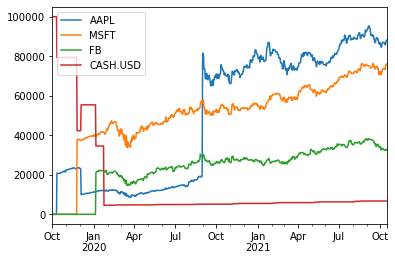

In [9]:
portfolio.holdings.plot()

<AxesSubplot:>

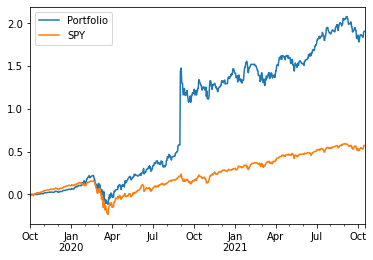

In [10]:
portfolio.benchmark('SPY').plot()

<AxesSubplot:ylabel='2021-10-17 00:00:00'>

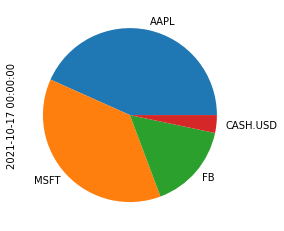

In [11]:
portfolio.holdings.iloc[-1,].plot.pie()

<AxesSubplot:ylabel='Frequency'>

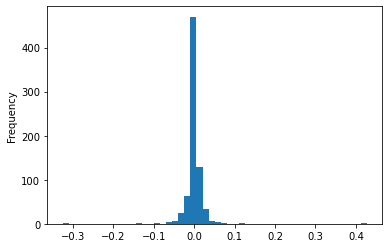

In [12]:
portfolio.daily_log_ret.plot.hist(bins=50)